In [1]:
import sys
import os
sys.path.append("/home/yons/Desktop/developer-luo/SWatNet")
os.chdir("/home/yons/Desktop/developer-luo/SWatNet")

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random
import time
from utils.utils import imgShow, imsShow, image_aug
from trainer.helper import plot_dset_one, fig2tensor, miou_binary, FocalLoss, DiceLoss_2d
from trainer.helper import img_vis_callback, lr_scheduler_callback, best_model_save_callback, time_record_callback
from dataPrepare.tfrecord_s1 import tfrecord_s1_scene, tfrecord_s1_patch
from models.models import UNet_x3, UNet_triple, UNet_gru_triple, UNet_triple_v2

In [3]:
## super parameters
BATCH_SIZE = 8
BUFFER_SIZE = 200
path_savedmodel = 'models/pretrained_model'

### training dataset (!!your dataset(.tfrecords file) directory)
traScene_file = 'data/traScene.tfrecords'
evaPatch_file = 'data/evaPatch_256_512_2048_50x.tfrecords'

In [4]:
## load training scenes from tfrecord file
tfrecord_scene_ins = tfrecord_s1_scene()
traScene = tf.data.TFRecordDataset(traScene_file)

tra_patch_group = traScene.map(tfrecord_scene_ins.parse_sceneSample)\
                            .map(tfrecord_scene_ins.parse_sceneShape)\
                            .cache()\
                            .map(tfrecord_scene_ins.toPatchGroup_fromScene,\
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                            .map(image_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                            .repeat(4)\
                            .prefetch(tf.data.experimental.AUTOTUNE)

# tra_dset = tra_patch_group.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tra_dset = tra_patch_group.batch(BATCH_SIZE)
print(tra_dset)

<BatchDataset shapes: (((None, 256, 256, 4), (None, 256, 256, 4), (None, 256, 256, 4)), (None, 256, 256, 1)), types: ((tf.float32, tf.float32, tf.float32), tf.float32)>


In [5]:
#### load the evaluation patches data. 
tfrecord_patch_ins = tfrecord_s1_patch()
test_dset = tf.data.TFRecordDataset(evaPatch_file)
test_dset = test_dset.map(tfrecord_patch_ins.parse_patchSample)\
                    .map(tfrecord_patch_ins.parse_patchShape)\
                    .map(tfrecord_patch_ins.toPatchGroup)\
                    .cache()

test_dset = test_dset.batch(12)
print(test_dset)

<BatchDataset shapes: (((None, 256, 256, 4), (None, 256, 256, 4), (None, 256, 256, 4)), (None, 256, 256, 1)), types: ((tf.float32, tf.float32, tf.float32), tf.float32)>


In [6]:
# # path_model = 'models/pretrained_model/model_triple_9376'
# # model = tf.keras.models.load_model(path_model)  # load model
path_weights = 'models/pretrained_model/UNet_gru_triple/weights_epoch_200_floss_lr0001'
# model = UNet_x3(nclass=2)
# model = UNet_triple(nclass=2)
# model = UNet_triple_v2(scale_high=2048, scale_mid=512, scale_low=256, nclass=2)
model = UNet_gru_triple(scale_high=2048, scale_mid=512, scale_low=256, nclass=2,
                                        trainable_gru=False, trainable_unet=True)
model.load_weights(path_weights)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.95)

# model_loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_loss = FocalLoss()
# model_loss = DiceLoss_2d()


weight_high: 1.000000, weight_mid: 1.000000, weight_low: 1.000000


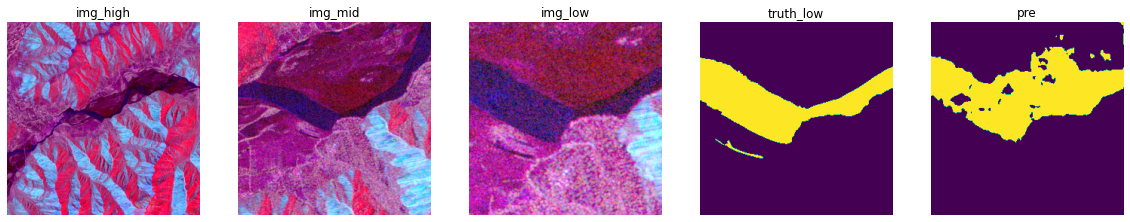

weight_high: 1.000000, weight_mid: 1.000000, weight_low: 1.000000


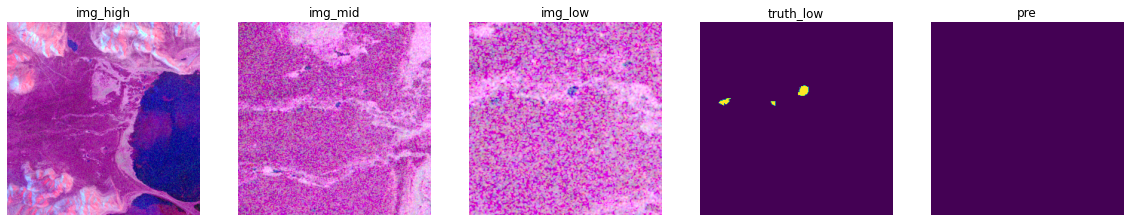

In [7]:
tra_oa = tf.keras.metrics.BinaryAccuracy('tra_oa')
tra_miou = miou_binary(num_classes=2,name='tra_miou')
tra_loss_tracker = tf.keras.metrics.Mean(name="tra_loss")
test_oa = tf.keras.metrics.BinaryAccuracy('test_oa')
test_miou = miou_binary(num_classes=2,name='test_miou')
test_loss_tracker = tf.keras.metrics.Mean(name="test_loss")

## visulize the evaluation image
def plot_dset_one(model, dset, i_img=0):
    '''
    visualize one img and the truth in the tf.data.Dataset.
    input: tf.data.Dataset, and the image number.
    '''
    for (img_high, img_mid, img_low), truth_low in dset:
        pre, weight_low, weight_mid, weight_high = model([img_high, img_mid, img_low], training=False)
        # pre = model([img_high, img_mid, img_low], training=False)
        pre = tf.where(pre>0.5, 1, 0)
        img_high, img_mid, img_low, truth_low, pre = img_high.numpy(), img_mid.numpy(),img_low.numpy(),\
                                    truth_low.numpy(),pre.numpy()
        figure = imsShow([img_high[i_img], img_mid[i_img], img_low[i_img], truth_low[i_img], pre[i_img]],\
                ['img_high', 'img_mid', 'img_low', 'truth_low','pre'],[2,2,2,0,0], \
                            [[2,1,0], [2,1,0], [2,1,0], [0,0,0], [0,0,0]], figsize=(20,4))
        print('weight_high: {:f}, weight_mid: {:f}, weight_low: {:f}'.format(weight_high[i_img].numpy().squeeze(), \
                            weight_mid[i_img].numpy().squeeze(), weight_low[i_img].numpy().squeeze()))
        plt.show()
    return figure

figure = plot_dset_one(model, test_dset.take(2), i_img=6)

In [8]:
# Define the Keras TensorBoard
## log path
current_time = (dt.datetime.utcnow()+dt.timedelta(hours=8)).strftime("%Y%m%d-%H%M%S")
train_log_dir = "logs/tensorb/" + current_time + '/train'
test_log_dir = "logs/tensorb/" + current_time + '/test'
## tensorboard writer
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


In [9]:
@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        y_pre,_,_,_ = model(x, training=True)
        loss = model_loss(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    tra_loss_tracker.update_state(loss)
    tra_oa.update_state(y, y_pre)
    tra_miou.update_state(y, y_pre)
    return tra_loss_tracker.result(), tra_oa.result(), tra_miou.result()

@tf.function
def test_step(model, x, y):
    with tf.GradientTape() as tape:
        y_pre,_,_,_ = model(x, training=False)
        loss = model_loss(y, y_pre)
    test_loss_tracker.update_state(loss)
    test_oa.update_state(y, y_pre)
    test_miou.update_state(y, y_pre)
    return test_loss_tracker.result(), test_oa.result(), test_miou.result()

def train_loops(model, tra_dset, test_dset, epochs):
    max_pre = 0.8
    for epoch in range(epochs):
        start = time.time() 
        # train the model
        for x_batch, y_batch in tra_dset:            
            tra_loss_epoch,tra_oa_epoch,tra_miou_epoch = train_step(model, x_batch, y_batch)
        
        # test the model
        for x_batch, y_batch in test_dset:
            test_loss_epoch, test_oa_epoch, test_miou_epoch = test_step(model, x_batch, y_batch)
        tra_loss_tracker.reset_states(), tra_oa.reset_states(), tra_miou.reset_states()
        test_loss_tracker.reset_states(), test_oa.reset_states(), test_miou.reset_states()
        # write into tensorboard
        with train_summary_writer.as_default():
            tf.summary.scalar('learning rate', data=optimizer.learning_rate(epoch*16),      step=epoch)
            tf.summary.scalar('loss', data=tra_loss_epoch, step=epoch)
            tf.summary.scalar('oa', data=tra_oa_epoch, step=epoch)
            tf.summary.scalar('miou', data=tra_miou_epoch, step=epoch)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', data=test_loss_epoch, step=epoch)
            tf.summary.scalar('oa', data=test_oa_epoch, step=epoch)
            tf.summary.scalar('miou', data=test_miou_epoch, step=epoch)
        # visualize the results
        print('epoch {}: traLoss:{:.3f}, traOA:{:.2f}, traMIoU:{:.2f}; evaLoss:{:.3f}, evaOA:{:.2f}, evaMIoU:{:.2f}, time:{:.0f}s'.format(epoch + 1, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, test_loss_epoch, test_oa_epoch, test_miou_epoch, time.time() - start))
        if test_miou_epoch>max_pre:
            max_pre = test_miou_epoch
            model.save_weights(path_savedmodel+'/UNet_gru_triple/weights_epoch_%d'%(epoch+1))
        if epoch%5 == 0:
            figure = plot_dset_one(model, test_dset.take(1), i_img=np.random.randint(8))


epoch 1: traLoss:0.033, traOA:0.96, traMIoU:0.91; evaLoss:0.141, evaOA:0.88, evaMIoU:0.77, time:239s
weight_high: 1.000000, weight_mid: 1.000000, weight_low: 1.000000


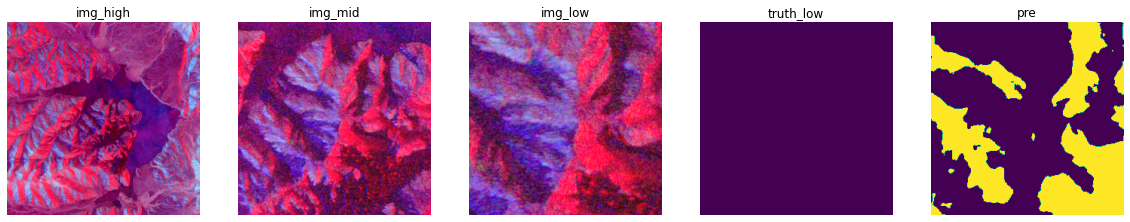

epoch 2: traLoss:0.028, traOA:0.97, traMIoU:0.93; evaLoss:0.231, evaOA:0.82, evaMIoU:0.67, time:8s
epoch 3: traLoss:0.024, traOA:0.97, traMIoU:0.94; evaLoss:0.794, evaOA:0.72, evaMIoU:0.43, time:8s
epoch 4: traLoss:0.037, traOA:0.97, traMIoU:0.94; evaLoss:1.198, evaOA:0.71, evaMIoU:0.39, time:8s
epoch 5: traLoss:0.025, traOA:0.97, traMIoU:0.93; evaLoss:0.895, evaOA:0.73, evaMIoU:0.45, time:8s
epoch 6: traLoss:0.024, traOA:0.97, traMIoU:0.94; evaLoss:0.069, evaOA:0.92, evaMIoU:0.84, time:8s
weight_high: 1.000000, weight_mid: 1.000000, weight_low: 1.000000


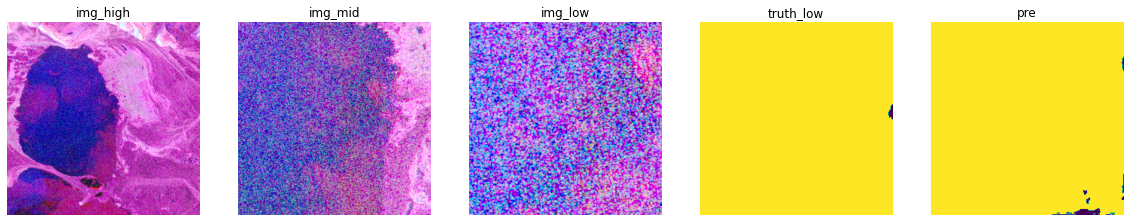

epoch 7: traLoss:0.019, traOA:0.98, traMIoU:0.96; evaLoss:0.065, evaOA:0.93, evaMIoU:0.84, time:8s
epoch 8: traLoss:0.019, traOA:0.97, traMIoU:0.95; evaLoss:0.171, evaOA:0.84, evaMIoU:0.68, time:8s


In [10]:
train_loops(model, tra_dset, test_dset, epochs=200)


In [ ]:
# %load_ext tensorboard
# !kill 328
# %tensorboard --logdir logs/tensorb/


In [ ]:
## model saving and loading
# path_model = 'logs/UNet_{:d}'.format(epoch)
# model.save(path_model)
# model.save_weights(path_model)
# model = tf.keras.models.load_model(path_model)  ## load model
# model.load_weights(path_model)